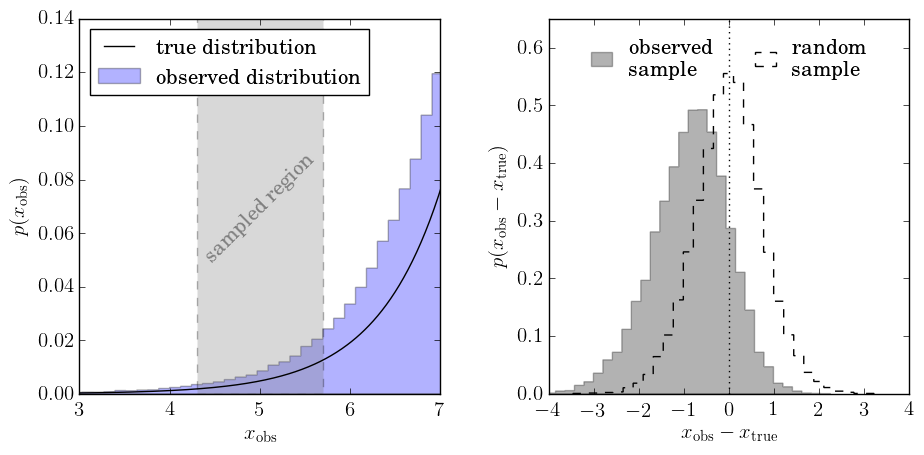

In [11]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.stats.random import trunc_exp

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

#------------------------------------------------------------
# Sample from a truncated exponential distribution
N = 1E6
N=int(N)
hmin = 4.3
hmax = 5.7
k = 0.6 * np.log(10)
true_dist = trunc_exp(hmin - 1.4,
                      hmax + 3.4,
                      0.6 * np.log(10))

# draw the true distributions and heteroscedastic noise
np.random.seed(0)
h_true = true_dist.rvs(N)
dh = 0.5 * (1 + np.random.random(N))
h_obs = np.random.normal(h_true, dh)

# create observational cuts
cut = (h_obs < hmax) & (h_obs > hmin)

# select a random (not observationally cut) subsample
rand = np.arange(len(h_obs))
np.random.shuffle(rand)
rand = rand[:cut.sum()]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

# First axes: plot the true and observed distribution
ax = fig.add_subplot(121)
bins = np.linspace(0, 12, 100)

x_pdf = np.linspace(0, 12, 1000)
ax.plot(x_pdf, true_dist.pdf(x_pdf), '-k',
        label='true distribution')
ax.hist(h_obs, bins, histtype='stepfilled',
        alpha=0.3, fc='b', normed=True,
        label='observed distribution')
ax.legend(loc=2, handlelength=2)

ax.add_patch(plt.Rectangle((hmin, 0), hmax - hmin, 1.2,
                           fc='gray', ec='k', linestyle='dashed',
                           alpha=0.3))
ax.text(5, 0.07, 'sampled region', rotation=45, ha='center', va='center',
        color='gray')

ax.set_xlim(hmin - 1.3, hmax + 1.3)
ax.set_ylim(0, 0.14001)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel(r'$x_{\rm obs}$')
ax.set_ylabel(r'$p(x_{\rm obs})$')

# Second axes: plot the histogram of (x_obs - x_true)
ax = fig.add_subplot(122)
bins = 30
ax.hist(h_obs[cut] - h_true[cut], bins, histtype='stepfilled',
        alpha=0.3, color='k', normed=True, label='observed\nsample')
ax.hist(h_obs[rand] - h_true[rand], bins, histtype='step',
        color='k', linestyle='dashed', normed=True, label='random\nsample')
ax.plot([0, 0], [0, 1], ':k')
ax.legend(ncol=2, loc='upper center', frameon=False, handlelength=1)

ax.set_xlim(-4, 4)
ax.set_ylim(0, 0.65)
ax.set_xlabel(r'$x_{\rm obs} - x_{\rm true}$')
ax.set_ylabel(r'$p(x_{\rm obs} - x_{\rm true})$')
plt.show()

An illustration of the bias in a subsample selected using measurements with finite
errors, when the population distribution is a steep function. The sample is drawn from the
distribution p(x) ∝ 10 0.6x , shown by the solid line in the left panel, and convolved with
heteroscedastic errors with widths in the range 0.5 < σ < 1.5. When a subsample is selected
using “measured” values, as illustrated in the left panel, the distribution of differences between
the “observed” and true values is biased, as shown by the histogram in the right panel. The
distribution is biased because more objects with larger true x are scattered into the subsample
from the right side, than from the left side where the true x are smaller.

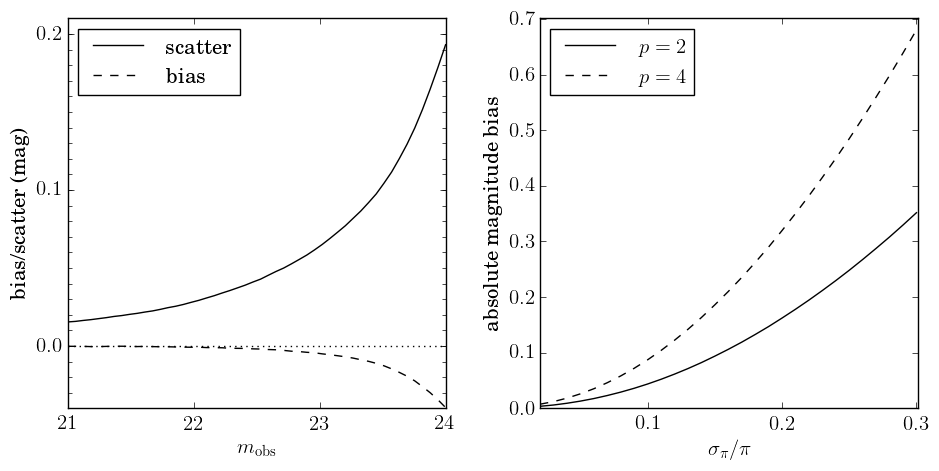

In [31]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.stats import median_sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)


def generate_magnitudes(N, k=0.6, m_min=20, m_max=25):
    """
    generate magnitudes from a distribution with
      p(m) ~ 10^(k m)
    """
    klog10 = k * np.log(10)
    Pmin = np.exp(klog10 * m_min)
    Pmax = np.exp(klog10 * m_max)
    return (1. / klog10) * np.log(Pmin + (Pmax - Pmin) * np.random.random(N))

generate_magnitudes(100)

def mag_errors(m_true, m5=24.0, fGamma=0.039):
    """
    compute magnitude errors based on the true magnitude and the
    5-sigma limiting magnitude, m5
    """
    x = 10 ** (0.4 * (mtrue - m5))
    return np.sqrt((0.04 - fGamma) * x + fGamma * x ** 2)

#----------------------------------------------------------------------
# Compute the Eddington-Malmquist bias & scatter

mtrue = generate_magnitudes(N, m_min=20, m_max=25)
photomErr = mag_errors(mtrue)

m1 = mtrue + np.random.normal(0, photomErr)
m2 = mtrue + np.random.normal(0, photomErr)
dm = m1 - m2

mGrid = np.linspace(21, 24, 50)
medGrid = np.zeros(mGrid.size)
sigGrid = np.zeros(mGrid.size)

for i in range(mGrid.size):
    medGrid[i], sigGrid[i] = median_sigmaG(dm[m1 < mGrid[i]])

#----------------------------------------------------------------------
# Lutz-Kelker bias and scatter

mtrue = generate_magnitudes(N, m_min=17, m_max=20)
relErr = 0.3 * 10 ** (0.4 * (mtrue - 20))

pErrGrid = np.arange(0.02, 0.31, 0.01)

deltaM2 = 5 * np.log(1 + 2 * relErr ** 2)
deltaM4 = 5 * np.log(1 + 4 * relErr ** 2)

med2 = [np.median(deltaM2[relErr < e]) for e in pErrGrid]
med4 = [np.median(deltaM4[relErr < e]) for e in pErrGrid]

#----------------------------------------------------------------------
# plot results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.17, top=0.95)

ax = fig.add_subplot(121)
ax.plot(mGrid, sigGrid, '-k', label='scatter')
ax.plot(mGrid, medGrid, '--k', label='bias')
ax.plot(mGrid, 0 * mGrid, ':k', lw=1)
ax.legend(loc=2)

ax.set_xlabel(r'$m_{\rm obs}$')
ax.set_ylabel('bias/scatter (mag)')

ax.set_ylim(-0.04, 0.21)
ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))

for l in ax.yaxis.get_minorticklines():
    l.set_markersize(3)

ax = fig.add_subplot(122)
ax.plot(pErrGrid, med2, '-k', label='$p=2$')
ax.plot(pErrGrid, med4, '--k', label='$p=4$')
ax.legend(loc=2)
ax.set_xlabel(r'$\sigma_\pi / \pi$')
ax.set_ylabel('absolute magnitude bias')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.set_xlim(0.02, 0.301)
ax.set_ylim(0, 0.701)

plt.show()

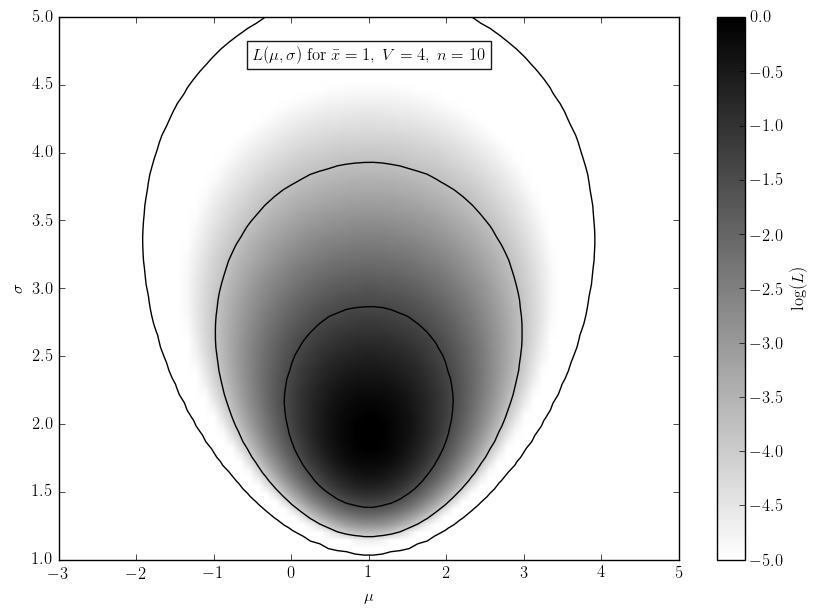

In [32]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)


def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.57: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

plt.show()

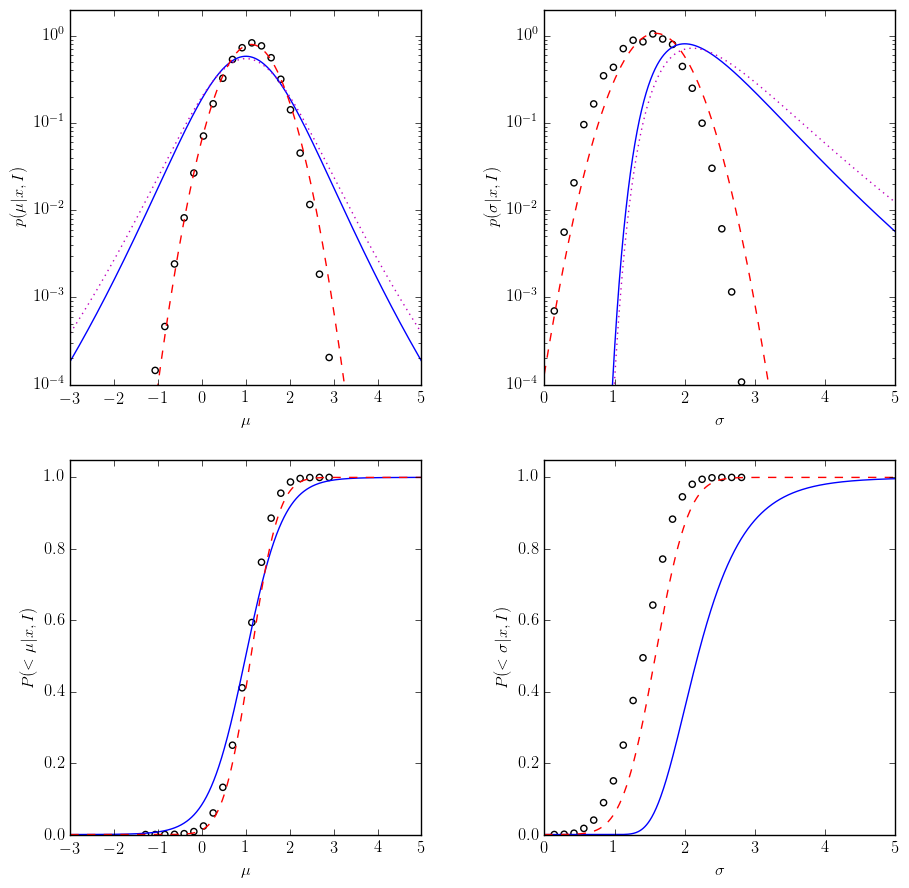

In [33]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.stats import mean_sigma
from astroML.resample import bootstrap

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)


#------------------------------------------------------------
# Define functions for computations below
#  These are expected analytic fits to the posterior distributions
def compute_pmu(mu, xbar, V, n):
    return (1 + (xbar - mu) ** 2 / V) ** (-0.5 * n)


def compute_pmu_alt(mu, xbar, V, n):
    return (1 + (xbar - mu) ** 2 / V) ** (-0.5 * (n - 1))


def compute_psig(sig, V, n):
    return (sig ** -n) * np.exp(-0.5 * n * V / sig ** 2)


def compute_psig_alt(sig, V, n):
    return (sig ** -(n - 1)) * np.exp(-0.5 * n * V / sig ** 2)


def gaussian(x, mu, sigma):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


#------------------------------------------------------------
# Draw a random sample from the distribution, and compute
# some quantities
n = 10
xbar = 1
V = 4
sigma_x = np.sqrt(V)

np.random.seed(10)
xi = np.random.normal(xbar, sigma_x, size=n)

mu_mean, sig_mean = mean_sigma(xi, ddof=1)

# compute the analytically expected spread in measurements
mu_std = sig_mean / np.sqrt(n)
sig_std = sig_mean / np.sqrt(2 * (n - 1))

#------------------------------------------------------------
# bootstrap estimates
mu_bootstrap, sig_bootstrap = bootstrap(xi, 1E6, mean_sigma,
                                        kwargs=dict(ddof=1, axis=1))

#------------------------------------------------------------
# Compute analytic posteriors

# distributions for the mean
mu = np.linspace(-3, 5, 1000)
dmu = mu[1] - mu[0]

pmu = compute_pmu(mu, 1, 4, 10)
pmu /= (dmu * pmu.sum())

pmu2 = compute_pmu_alt(mu, 1, 4, 10)
pmu2 /= (dmu * pmu2.sum())

pmu_norm = gaussian(mu, mu_mean, mu_std)
pmu_norm /= (dmu * pmu_norm.sum())

mu_hist, mu_bins = np.histogram(mu_bootstrap, 20)
mu_dbin = np.diff(mu_bins).astype(float)
mu_hist = mu_hist / mu_dbin / mu_hist.sum()

# distributions for the standard deviation
sig = np.linspace(1E-4, 8, 1000)
dsig = sig[1] - sig[0]
psig = compute_psig(sig, 4, 10)
psig /= (dsig * psig.sum())

psig2 = compute_psig_alt(sig, 4, 10)
psig2 /= (dsig * psig2.sum())

psig_norm = gaussian(sig, sig_mean, sig_std)
psig_norm /= (dsig * psig_norm.sum())

sig_hist, sig_bins = np.histogram(sig_bootstrap, 20)
sig_dbin = np.diff(sig_bins).astype(float)
sig_hist = sig_hist / sig_dbin / sig_hist.sum()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.35, right=0.95,
                    hspace=0.2, top=0.95)

# plot posteriors for mu
ax1 = plt.subplot(221, yscale='log')
ax1.plot(mu, pmu, '-b')
ax1.plot(mu, pmu2, ':m')
ax1.plot(mu, pmu_norm, '--r')
ax1.scatter(mu_bins[1:] - 0.5 * mu_dbin, mu_hist,
            color='k', facecolor='none')

ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$p(\mu|x,I)$')

ax2 = plt.subplot(223, sharex=ax1)
ax2.plot(mu, pmu.cumsum() * dmu, '-b')
ax2.plot(mu, pmu_norm.cumsum() * dmu, '--r')
ax2.scatter(mu_bins[1:] - 0.5 * mu_dbin, mu_hist.cumsum() * mu_dbin,
            color='k', facecolor='none')
ax2.set_xlim(-3, 5)

ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$P(<\mu|x,I)$')

# plot posteriors for sigma
ax3 = plt.subplot(222, sharey=ax1)
ax3.plot(sig, psig, '-b')
ax3.plot(sig, psig2, ':m')
ax3.plot(sig, psig_norm, '--r')
ax3.scatter(sig_bins[1:] - 0.5 * sig_dbin, sig_hist,
            color='k', facecolor='none')
ax3.set_ylim(1E-4, 2)

ax3.set_xlabel(r'$\sigma$')
ax3.set_ylabel(r'$p(\sigma|x,I)$')

ax4 = plt.subplot(224, sharex=ax3, sharey=ax2)
ax4.plot(sig, psig.cumsum() * dsig, '-b')
ax4.plot(sig, psig_norm.cumsum() * dsig, '--r')
ax4.scatter(sig_bins[1:] - 0.5 * sig_dbin, sig_hist.cumsum() * sig_dbin,
            color='k', facecolor='none')
ax4.set_ylim(0, 1.05)
ax4.set_xlim(0, 5)

ax4.set_xlabel(r'$\sigma$')
ax4.set_ylabel(r'$P(<\sigma|x,I)$')

plt.show()